# Dimensionality Reduction and Clustering of UK Biobank Asthma Patients

This notebook does the following:

* Reads in a sample of UKBB Asthma patients
* Performs dimensionality reduction on UKBB Asthma Patients with PCA and finds the optimal number of principal components
* Performs dimensionality reduction on UKBB Asthma patients wit tSNE, using the otpimal number of principal components
* Performs kMeans clustering to find any clusters of UKBB asthma patients



In [7]:
import pandas as pd 
import numpy as np
%matplotlib inline
from matplotlib import rc
rc('font', **{'family':'sans-serif','sans-serif':['Helvetica']})
#rc('text', usetex=False)
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(12,6)

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn import decomposition
from sklearn import manifold
from sklearn.cluster import KMeans 

# Step 1: Read in UKBB asthma patients and subselect data

Fields in UKBB phenotype data come in three types:

1) 'QUANTITY' fields - these fields are continuous variables. Integers and Decimal numbers
2) 'CATEGORY' fields - these fields are not continuous. There are a limited number of integers which label specfic category values
3) 'BIN' fields - these are binary fields. They only have two possible values. They only label a field as being 'TRUE' or 'FALSE' 

For summary statistics and finding the most correlated variables, we only selected 'QUANTITY' fields.  For dimensionality reduction for further clustering, it's not so clear whether we have to select only 'QUANTITY' fields.

In [8]:
#Read in 5K sample
#asthma_df=pd.read_csv("ukbb_asthma_sample_5k.csv",sep='\t')
#asthma_df=pd.read_csv("ukbb_asthma_sample_5k_new.csv",sep='\t')

In [9]:
asthma_df=pd.read_csv("ukbb_asthma_full_filtered.csv",sep='\t')

In [10]:
asthma_df.columns

Index([u'age', u'BMI', u'asthma',
       u'f_20006_0_0_f_QUANT_Interpolated_Year_when_cancer_first_diagnosed',
       u'f_20008_0_0_f_QUANT_Interpolated_Year_when_non_cancer_illness_first_diagnosed',
       u'f_20010_0_0_f_QUANT_Interpolated_Year_when_operation_took_place',
       u'f_20018_0_0_f_QUANT_Prospective_memory_result',
       u'f_22508_0_0_f_QUANT_Amount_of_tobacco_currently_smoked',
       u'f_1160_0_0_f_QUANT_Sleep_duration',
       u'f_1269_0_0_f_QUANT_Exposure_to_tobacco_smoke_at_home',
       ...
       u'specialRequest_ageSquared_QUANT_age_squared',
       u'specialRequest_QUANT_years_observed_in_primary_HES',
       u'specialRequest_QUANT_type_of_asthma_exacerbation',
       u'specialRequest_QUANT_asthma_hospital_exacerbations_raw',
       u'specialRequest_QUANT_asthma_hospital_exacerbations_annual_rate',
       u'specialRequest_QUANT_asthma_HES_based_age_of_onset',
       u'specialRequest_QUANT_asthma_HES_or_NI_based_age_of_onset_youngest',
       u'specialRequest_QU

In [11]:
# Select columns to filter on
cols = [col for col in asthma_df.columns if 'HES_p' not in col and 'PC' not in col]

In [12]:
#asthma_df=asthma_df[cols].drop('Unnamed: 0',axis=1)

In [13]:
#select only 'QUANTITY' fields
asthma_df_quant=asthma_df.loc[:, asthma_df.columns.str.contains('QUANT|age|BMI')].fillna(0.0)
#select only fields with 10 or more unique values
for col in asthma_df_quant.columns:
    if len(asthma_df_quant[col].unique()) < 20 :
        asthma_df_quant.drop(col,inplace=True,axis=1)

        
#select only 'QUANTITY' and "CATEGORY" fields
#asthma_df_quant_cat=asthma_df.loc[:, asthma_df.columns.str.contains('QUANT|age|BMI|CAT|sex')].fillna(0.0)
#asthma_df_quant_cat=asthma_df_quant_cat.drop(columns=['f_22182_0_0_f_CAT_HLA_imputation_values_and_quality'])
#selects all features. 

#asthma_df_all=asthma_df.loc[:,~asthma_df.columns.str.contains('ID|random|chip|asthma')].fillna(0.0)
#asthma_df_all=asthma_df_all.drop(columns=['f_22182_0_0_f_CAT_HLA_imputation_values_and_quality'])


In [14]:
asthma_df_quant.shape

(61171, 779)

# Step 2: Reduce dimensions with PCA

The next step is to perform PCA to reduce the dimensions in the data set. PCA is straightforward with Python. It's not straightforward to identify the ideal number of Principal Components to use and which data to include. We have three data frames in this notebook:

* asthma_df_quant - this data frame only has 'QUANTITY' fields. This is exaclty the same as the exploratory analysis phase finding summary statistics and correlated/uncorrelated variables.
* asthma_df_quant_cat - this data frame has both 'QUANTITY' fields and 'CATEGORY' fields. This totals about 1500 features
* asthma_df_all - this data frame has everything - 'QUANTITY', 'CATEGORY', and 'BINARY' fields.


In this step we have to:

* Perform PCA in two configurations: Two principal components and the optimal number of principal components
* We need to perform this PCA on all three data frames listed above. 



## Data Scaling
Before dimensionality reduction and further clustering with kMeans, data has to be scaled. The standard scaler scales the data to an average value of 0 and a unit variance of 1. This is appropriate for the 'QUANTITY' features. We can't use the standard scaler for the other features, so we do 'min/max' scaling, which scales the data in the range from 0 to 1.


In [15]:
#Scale the quantity features only
data_quant=StandardScaler().fit_transform(asthma_df_quant.values)
#Scale the quantity AND CATEGORY features
#data_quant_cat=StandardScaler().fit_transform(asthma_df_quant_cat.applymap(lambda x: float(x)).values)
#Scale ALL THE features
#data_all=StandardScaler().fit_transform(asthma_df_all.applymap(lambda x:float(x)).values)


## PCA 

/opt/wakari/anaconda/envs/default/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


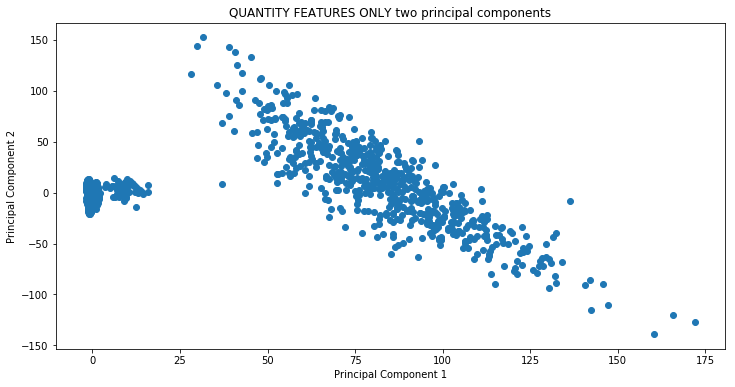

In [16]:
pca_2d = decomposition.PCA(n_components=2)
pca_quant_2d=pca_2d.fit_transform(data_quant)

plt.scatter(pca_quant_2d[:,0],pca_quant_2d[:,1])

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('QUANTITY FEATURES ONLY two principal components')
plt.show()

## Finding the optimal number of principal components for each three data frames

It's easier to talk about in person, but the best way to determine the optimal number of principal components is to plot the 'cummulative eigenvalue fraction' vs the number of eigenvalues. The code to do this is below. The example code is for 500 principal components - this is way too many. I'll explain why below:


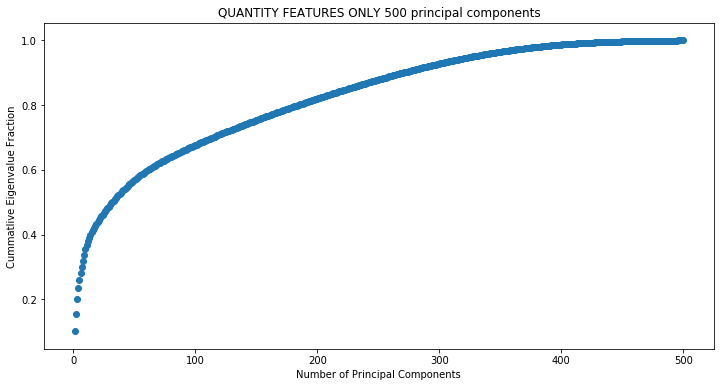

In [17]:
# PCA for 500 components
pca_500d = decomposition.PCA(n_components=500)
pca_quant_500d=pca_500d.fit_transform(data_quant)

# Calculate the cummalative eigenvalue fraction
eigen_fraction_500d=np.cumsum(pca_500d.explained_variance_)/(np.sum(pca_500d.explained_variance_))
#Plot the Results
plt.scatter(range(1,len(pca_500d.explained_variance_)+1),eigen_fraction_500d)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cummatlive Eigenvalue Fraction')
plt.title('QUANTITY FEATURES ONLY 500 principal components')
plt.show()

## Do you see how the plot is flat for most of it? It means 500 is way too many principal components. The optimal number of Principal components is when the above plot only starts to get flat. Copy and paste the code below to find the optimal number of Principal Components for all three data frames:

* Quantitative Features Only
* Quantitative + Categorical Features
* All Features

#### Hint

This is not as hard as it looks. You can reduce the number of principal components in the above plot (to say 150 or so) and pick out the optimal number of components by eye. 

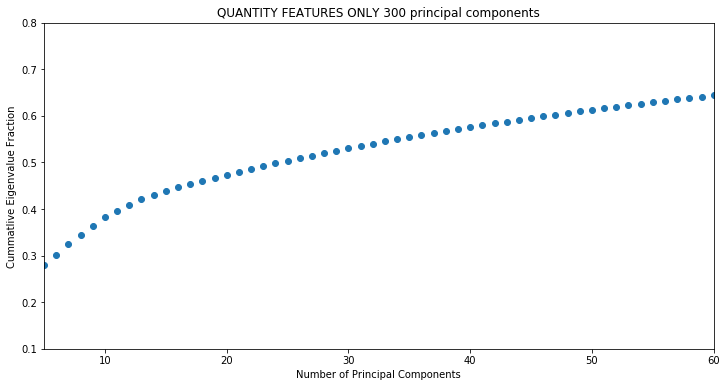

In [18]:
# PCA for 300 components

pca_300d = decomposition.PCA(n_components=300)
pca_quant_300d=pca_300d.fit_transform(data_quant)

# Calculate the cummalative eigenvalue fraction
eigen_fraction_300d=np.cumsum(pca_300d.explained_variance_)/(np.sum(pca_300d.explained_variance_))
#Plot the Results
plt.scatter(range(1,len(pca_300d.explained_variance_)+1),eigen_fraction_300d)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cummatlive Eigenvalue Fraction')
plt.xlim(5,60)
plt.ylim(0.1,0.8)
plt.title('QUANTITY FEATURES ONLY 300 principal components')
plt.show()

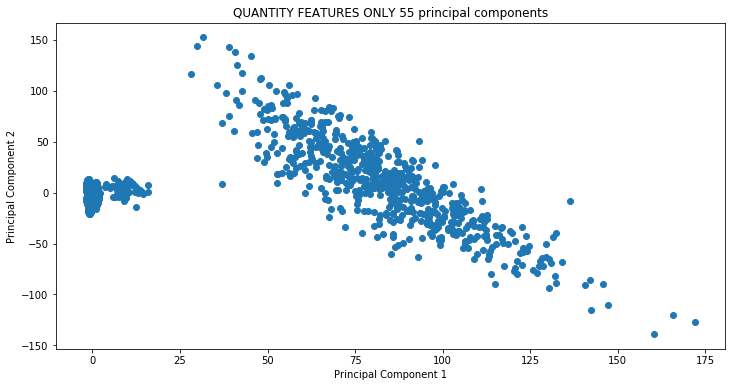

In [19]:
pca_55d = decomposition.PCA(n_components=55)
pca_quant_55d=pca_55d.fit_transform(data_quant)

plt.scatter(pca_quant_55d[:,0],pca_quant_55d[:,1])

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('QUANTITY FEATURES ONLY 55 principal components')
plt.show()

# Step 3: Dimensionality Reduction with tSNE

This part is straightforward. You will have to run the same code below and replace the number of dimensions with the optimal number of principal components you found above. You will have to do so again for all three data frames

In [20]:
'''tsne_2d = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=20,
                     learning_rate=300, n_iter=400)
    #tsne = manifold.TSNE(n_components=2, init='pca')
tsne_quant_2d=tsne_2d.fit_transform(data_quant)

plt.scatter(tsne_quant_2d[:,0],tsne_quant_2d[:,1])

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('QUANTITY FEATURES ONLY tSNE with two components')
plt.show()
'''


"tsne_2d = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=20,\n                     learning_rate=300, n_iter=400)\n    #tsne = manifold.TSNE(n_components=2, init='pca')\ntsne_quant_2d=tsne_2d.fit_transform(data_quant)\n\nplt.scatter(tsne_quant_2d[:,0],tsne_quant_2d[:,1])\n\nplt.xlabel('Dimension 1')\nplt.ylabel('Dimension 2')\nplt.title('QUANTITY FEATURES ONLY tSNE with two components')\nplt.show()\n"

In [21]:
"""tsne_2d = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=20,
                     learning_rate=300, n_iter=400)
    #tsne = manifold.TSNE(n_components=2, init='pca')
tsne_quant_2d=tsne_2d.fit_transform(pca_quant_55d)

plt.scatter(tsne_quant_2d[:,0],tsne_quant_2d[:,1])

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('QUANTITY FEATURES ONLY tSNE with two components')
plt.show()
"""

"tsne_2d = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=20,\n                     learning_rate=300, n_iter=400)\n    #tsne = manifold.TSNE(n_components=2, init='pca')\ntsne_quant_2d=tsne_2d.fit_transform(pca_quant_55d)\n\nplt.scatter(tsne_quant_2d[:,0],tsne_quant_2d[:,1])\n\nplt.xlabel('Dimension 1')\nplt.ylabel('Dimension 2')\nplt.title('QUANTITY FEATURES ONLY tSNE with two components')\nplt.show()\n"

# Step 4 - kMeans Clustering

We will have to do kMeans clustering on the data frame with quantitative features only, on the PCA transformed data. We will do kMeans on two different inputs:

* Two principal components 
* The optimal number of principal components (55)


## 2 principal component kMeans

From the PCA plots above, it looks like there are three clusters, possibly 4. A tSNE visualization on the PCA output would give us a better idea how many clusters there are likely to be. To perform kMeans clustering, you must perform the following steps:

* Run kMeans with the parameters n_init=15 and max_iter=400 on the 2-dimensional PCA output to find 3 clusters. Look at the documentation in http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html and https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
* Visualize the resulsting clusters on the 2-dimensional PCA scatter plot above. We want to just reproduce that plot and color the points with which cluster they belong to. Cell #4 in https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html demonstrates how to do this
* We next have to optimize the number of clusters. There are many ways to do this, but using the Silhouette Score to select the best number of clusters is probably the most direct and the fastest: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html and http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score Basically, we want the number of clusters such that the silhouette score (a measure of cluster separation) is as close to 1.0 as possible. Start with 2 clusters, Don't go over 8 clusters. 

## Optimal number (55) principal components

Repeat the above steps, but with 55 principal components. You can't visualize 55 dimensions of course, so just plot the first two principal components of the 55. 

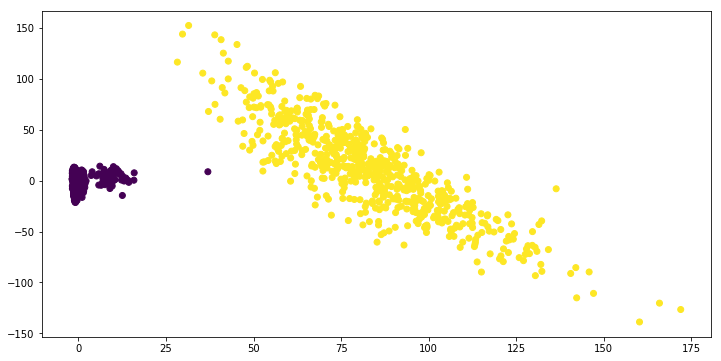

In [22]:
X = pca_quant_55d
kmeans = KMeans(n_clusters=2, n_init=15, max_iter=400).fit(X)
y_pred = kmeans.predict(X)

plt.scatter(X[:,0], X[:,1], c=y_pred)

In [23]:
len(y_pred)

61171

0.8003236106145404


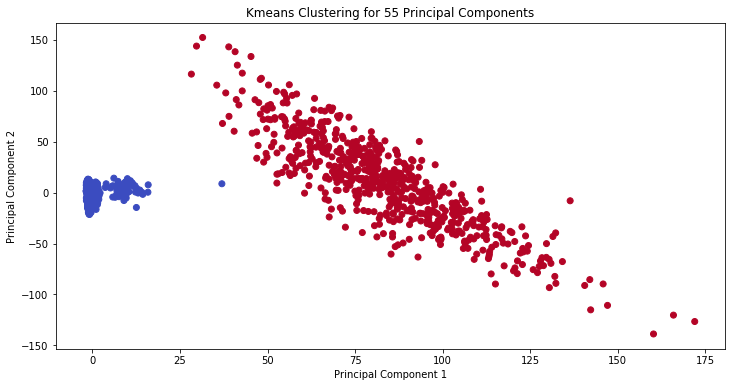

In [24]:
X = pca_quant_55d
kmeans = KMeans(n_clusters=2, n_init=15, max_iter=400)
from sklearn.metrics import silhouette_samples, silhouette_score
cluster_labels = kmeans.fit_predict(X)

silhouette_avg = silhouette_score(X, cluster_labels)
print(silhouette_avg)
plt.scatter(X[:,0], X[:,1], c=cluster_labels, cmap="coolwarm")
plt.title("Kmeans Clustering for 55 Principal Components")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()
#plt.savefig('kmeans_55d_scatterplot.png')

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MeanShift, estimate_bandwidth

X = pca_quant_55d
n=2
#clusterer = KMeans(n_clusters=n, random_state=1
clusterer = AgglomerativeClustering(n_clusters=n,linkage='average',affinity='l1')

cluster_labels = clusterer.fit_predict(X)

silhouette_avg = silhouette_score(X, cluster_labels)
print(silhouette_avg)
plt.scatter(X[:,0], X[:,1], c=cluster_labels)
plt.show()

# Step 5 - find which features contribute the most to PCA. 

In [25]:
## which variables change the data the most/ have the highest variance 

/local/apps/wakari/anaconda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in log


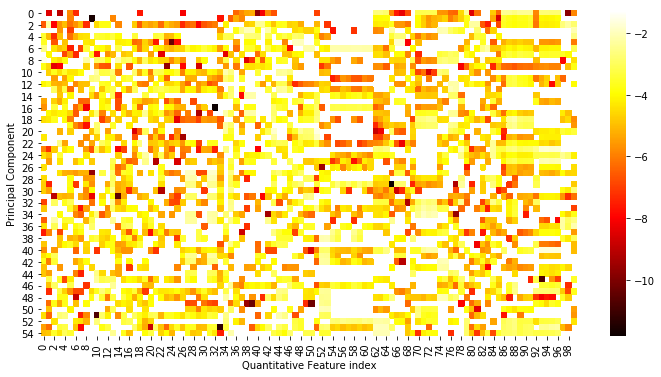

In [26]:
import seaborn as sns
plt.rcParams['figure.figsize']=(12,6)

sns.heatmap(np.log(pca_55d.inverse_transform(np.eye(pca_quant_55d.shape[1])))[:,0:100], cmap="hot", cbar=True)
plt.ylabel('Principal Component')
plt.xlabel('Quantitative Feature index')
plt.show()

In [27]:
## pale colors are most important 

### The above plot shows a heat map of feature importances. Because we have over 600 quantitative features, I only show 100. There are 55 principal components. The more yellow the heatmap is, the more important the feature is. Let's average over the principal components to get the most important features

In [28]:
log_importances=np.log(pca_55d.inverse_transform(np.eye(pca_quant_55d.shape[1])))

/local/apps/wakari/anaconda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


In [29]:
mean_log_importances=np.apply_along_axis(np.mean,0,np.nan_to_num(log_importances))
print(len(mean_log_importances))

779


In [30]:
mean_log_importances_df=pd.DataFrame(data=mean_log_importances,columns=['importance'])

In [31]:
mean_log_importances_df=mean_log_importances_df.reset_index()
print(mean_log_importances_df.head(15))

    index  importance
0       0   -2.676006
1       1   -2.482571
2       2   -2.187262
3       3   -2.694750
4       4   -2.201851
5       5   -2.663930
6       6   -2.677477
7       7   -2.518011
8       8   -2.651156
9       9   -2.210778
10     10   -1.657518
11     11   -2.125427
12     12   -2.321709
13     13   -1.783814
14     14   -3.041993


### The numpy array above is an array of importances, of length 638. They map back to the original data frame:

In [32]:
print(asthma_df_quant.columns[0],asthma_df_quant.columns[637])

('age', 'f_20157_0_0_f_QUANT_Duration_to_complete_alphanumeric_path_trail_2_residualizedRelated')


In [33]:
## every entry in array, can get variabe name 

# Find the ten most important features to start, including their names, to focus on. 

In [34]:
## labels 0-638: have value associated. 
## output array as csv file -- find 10 highest values in the array and associated array index number 

np.savetxt("Asthma Important Features.csv", mean_log_importances_df, delimiter=",")

In [35]:
asthma_df_important_features = mean_log_importances_df.sort_values(by="importance", ascending=False)
print(asthma_df_important_features.head(15))

     index  importance
109    109   -1.229521
584    584   -1.312077
357    357   -1.334944
113    113   -1.353731
41      41   -1.362257
228    228   -1.376823
449    449   -1.391536
97      97   -1.417307
411    411   -1.419085
56      56   -1.450074
60      60   -1.457951
61      61   -1.470489
57      57   -1.470791
617    617   -1.474340
608    608   -1.488014


# Step 6: ANOVA of the ten most important features between the two clusters

In [36]:
# Add the group label to the data frame:
asthma_df_quant['Cluster Label']=y_pred
asthma_df_quant['Cluster Label']=asthma_df_quant['Cluster Label'].apply(str).apply(lambda x: x.replace('0','A')).apply(lambda x: x.replace('1','B'))

In [37]:
asthma_df_quant.shape

(61171, 780)

### adding the cluster labels allows you to visualize box plots broken down by cluster easily. For example, for age:

In [38]:
## include box plots for top 10 variables 

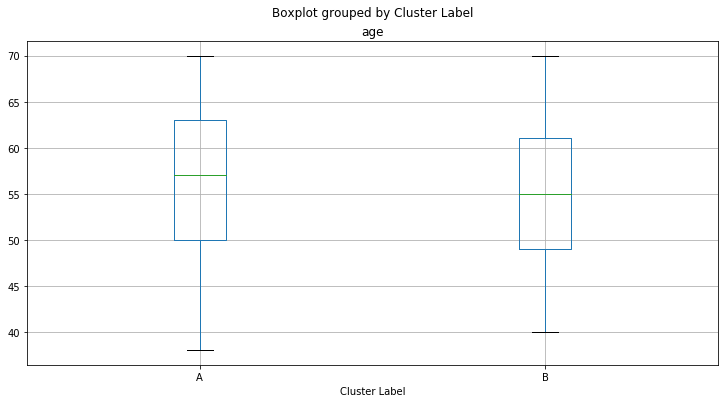

In [39]:
asthma_df_quant.boxplot(asthma_df_quant.columns[0],by='Cluster Label')

In [40]:
v = asthma_df_important_features['index'].values[0]

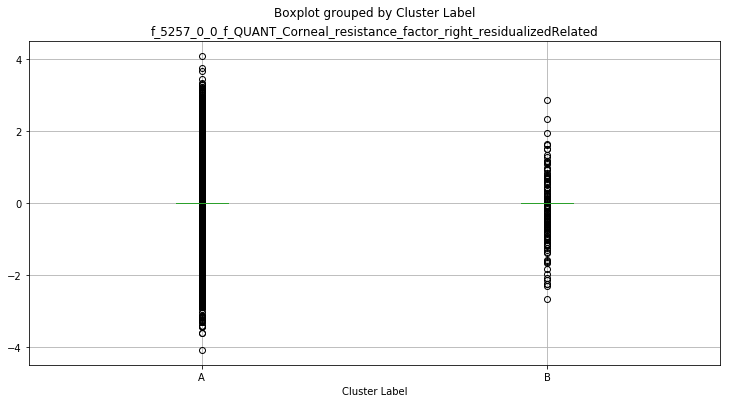

In [41]:
asthma_df_quant.boxplot(asthma_df_quant.columns[449],by='Cluster Label')

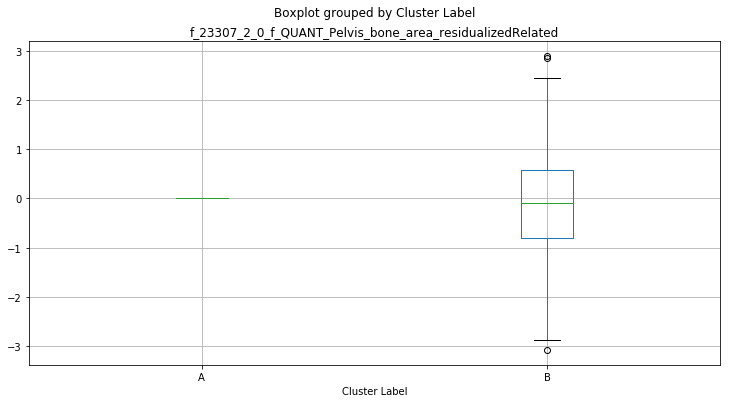

In [42]:
asthma_df_quant.boxplot(asthma_df_quant.columns[584],by='Cluster Label')

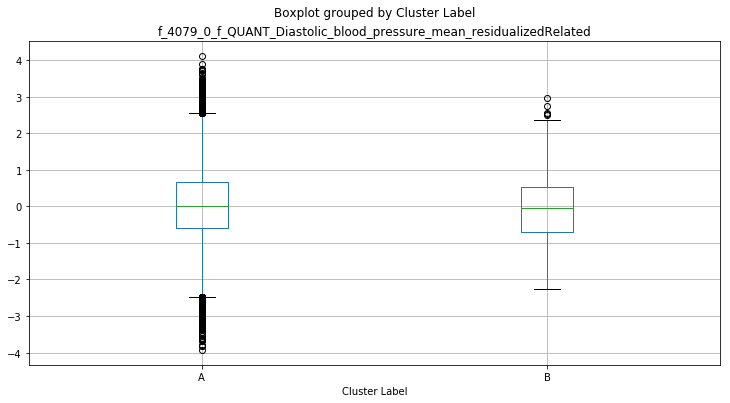

In [43]:
asthma_df_quant.boxplot(asthma_df_quant.columns[659],by='Cluster Label')

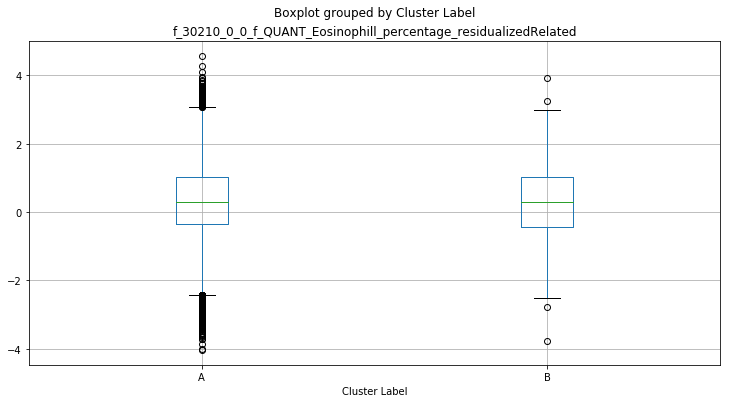

In [44]:
asthma_df_quant.boxplot(asthma_df_quant.columns[617],by='Cluster Label')

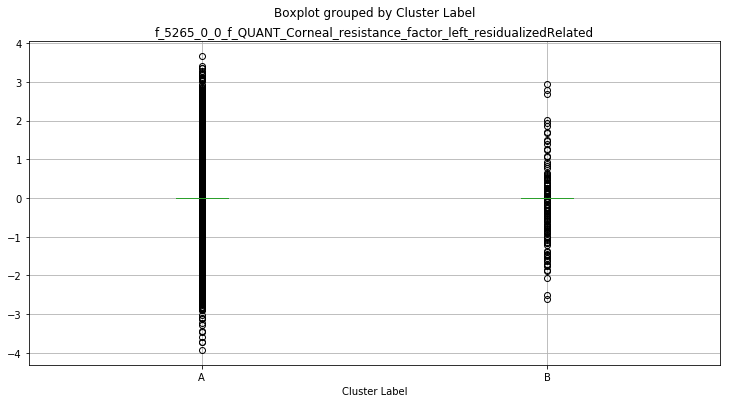

In [45]:
asthma_df_quant.boxplot(asthma_df_quant.columns[453],by='Cluster Label')

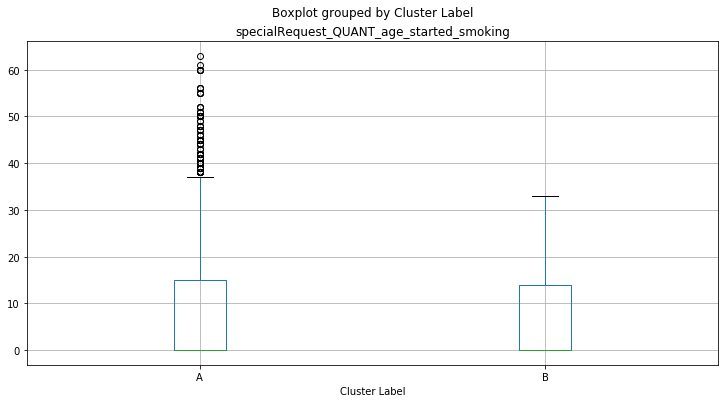

In [46]:
asthma_df_quant.boxplot(asthma_df_quant.columns[357],by='Cluster Label')

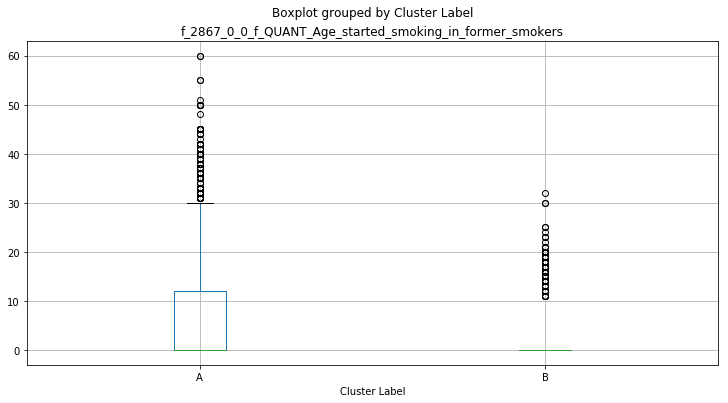

In [47]:
asthma_df_quant.boxplot(asthma_df_quant.columns[10],by='Cluster Label')

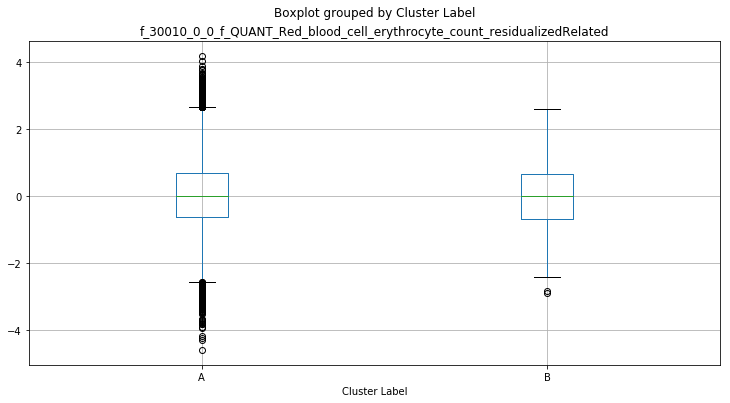

In [48]:
asthma_df_quant.boxplot(asthma_df_quant.columns[597],by='Cluster Label')

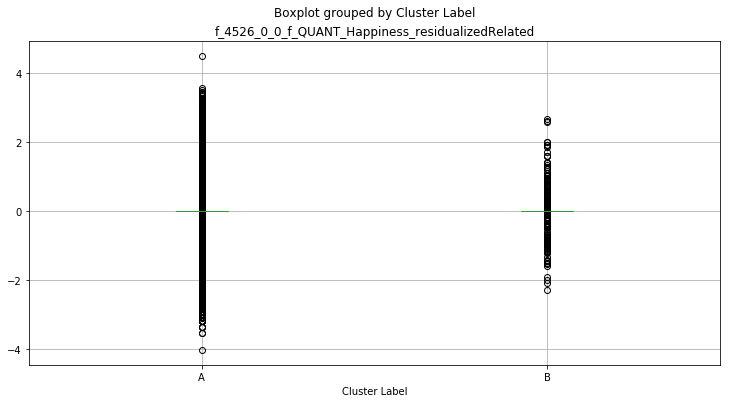

In [49]:
asthma_df_quant.boxplot(asthma_df_quant.columns[411],by='Cluster Label')

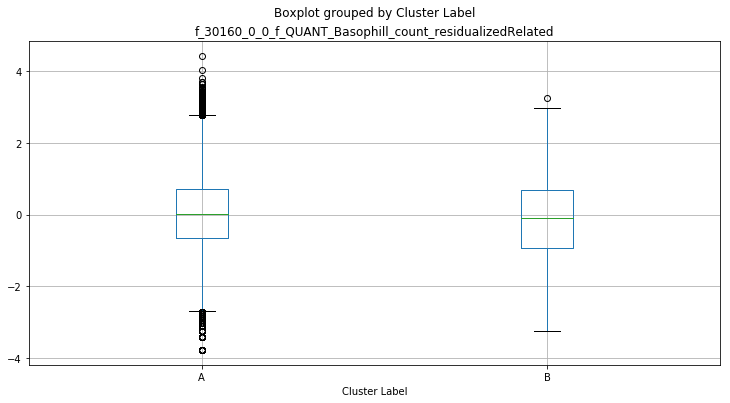

In [50]:
asthma_df_quant.boxplot(asthma_df_quant.columns[612],by='Cluster Label')

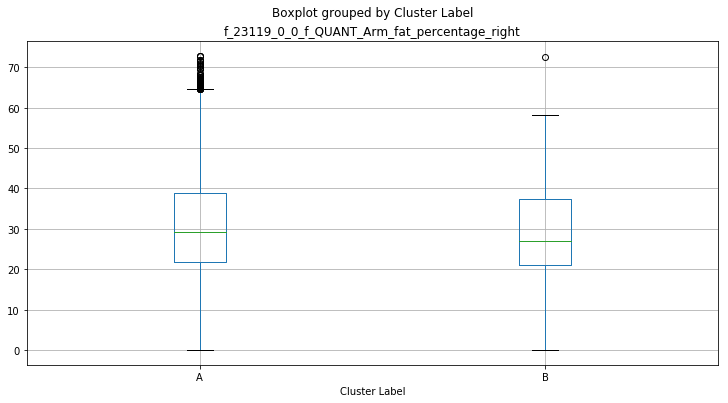

In [51]:
asthma_df_quant.boxplot(asthma_df_quant.columns[109],by='Cluster Label')

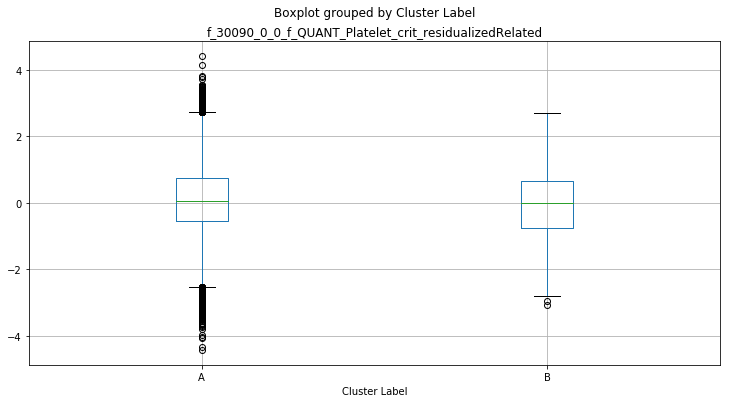

In [52]:
asthma_df_quant.boxplot(asthma_df_quant.columns[605],by='Cluster Label')

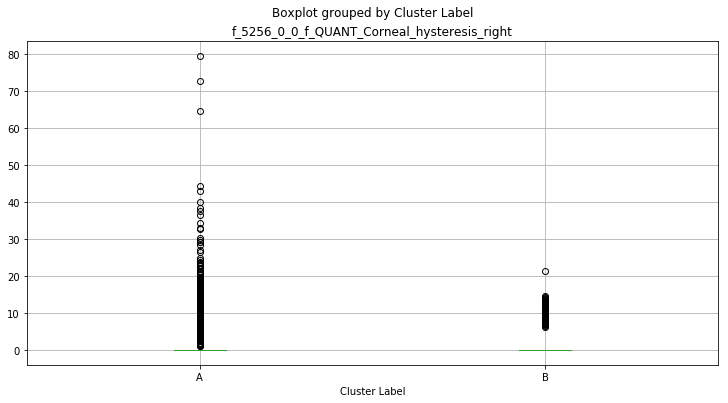

In [53]:
asthma_df_quant.boxplot(asthma_df_quant.columns[56],by='Cluster Label')

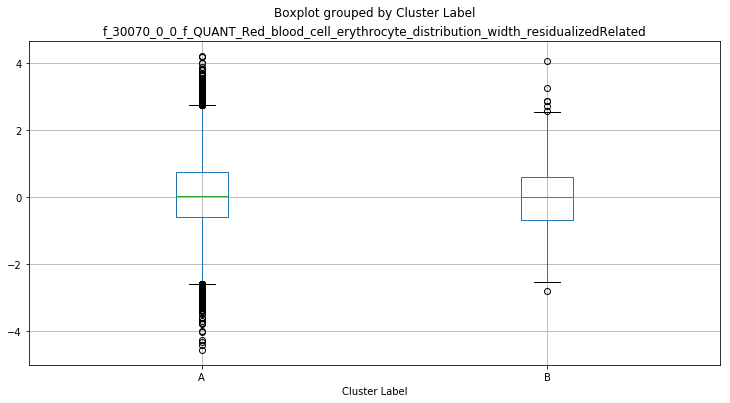

In [54]:
asthma_df_quant.boxplot(asthma_df_quant.columns[603],by='Cluster Label')

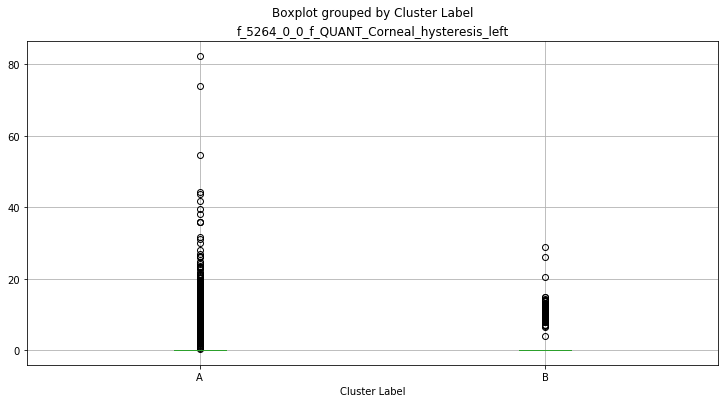

In [55]:
asthma_df_quant.boxplot(asthma_df_quant.columns[60],by='Cluster Label')

### which means the Data is not clustering by age. 

1) Visualize the data in box plots for all ten most important features
2) Run ANOVA on the ten most important features above to derive p-values. Good resources for ANOVA in Python include: https://www.marsja.se/four-ways-to-conduct-one-way-anovas-using-python/ (first section with SciPy only) 

and

https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.stats.f_oneway.html



# ANOVA - analyzes groups of data (group A vs B) to quantify how different they are 
## do each variable separately - 15 different ANOVA's
## lower the better p-value. we define the cutoff ( < 0.05)

In [59]:
asthma_df_quant_group1 = asthma_df_quant[asthma_df_quant['Cluster Label'].str.contains('A')]

asthma_df_quant_group2 = asthma_df_quant[asthma_df_quant['Cluster Label'].str.contains('B')]

In [60]:
[asthma_df_quant.columns[381]]


['f_3786_0_0_f_QUANT_Age_asthma_diagnosed_residualizedRelated']

In [61]:
import scipy.stats as stats

feature = asthma_df_quant.columns[449]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))
## if pvalue < 0.05:

   

ANOVA Statistic 7.160612893392889 and p-value 0.007454157476362064


In [62]:
feature = asthma_df_quant.columns[584]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))

ANOVA Statistic 993.5124228226186 and p-value 2.5189051910182446e-216


In [63]:
feature = asthma_df_quant.columns[659]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))

ANOVA Statistic 4.683874271915652 and p-value 0.03045086381438937


In [64]:
feature = asthma_df_quant.columns[617]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))

ANOVA Statistic 0.337180446810969 and p-value 0.5614633996534308


In [65]:
[asthma_df_quant.columns[453]]

['f_5265_0_0_f_QUANT_Corneal_resistance_factor_left_residualizedRelated']

In [66]:
feature = asthma_df_quant.columns[453]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))

ANOVA Statistic 3.165118373022105 and p-value 0.07523194670522179


In [67]:
feature = asthma_df_quant.columns[357]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))

ANOVA Statistic 3.6864334910717877 and p-value 0.05486144288856012


In [68]:
feature = asthma_df_quant.columns[10]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))

ANOVA Statistic 1.0555423528730155 and p-value 0.3042381398745969


In [69]:
feature = asthma_df_quant.columns[597]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))

ANOVA Statistic 0.8042892843346484 and p-value 0.36981755971151353


In [70]:
[asthma_df_quant.columns[411]]

['f_4526_0_0_f_QUANT_Happiness_residualizedRelated']

In [71]:
feature = asthma_df_quant.columns[411]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))

ANOVA Statistic 0.008086018973845324 and p-value 0.9283492591964536


In [72]:
[asthma_df_quant.columns[612]]

['f_30160_0_0_f_QUANT_Basophill_count_residualizedRelated']

In [73]:
feature = asthma_df_quant.columns[612]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))

ANOVA Statistic 16.573210910414602 and p-value 4.6866341322968534e-05


In [74]:
feature = asthma_df_quant.columns[109]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))

ANOVA Statistic 8.963074207463185 and p-value 0.0027560101552165576


In [75]:
feature = asthma_df_quant.columns[605]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))

ANOVA Statistic 13.017113242979384 and p-value 0.0003089031488269694


In [76]:
feature = asthma_df_quant.columns[56]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))

ANOVA Statistic 0.23363755466667072 and p-value 0.6288413862495658


In [77]:
feature = asthma_df_quant.columns[603]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))

ANOVA Statistic 4.548635059889868 and p-value 0.03294896910125065


In [78]:
feature = asthma_df_quant.columns[60]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))

ANOVA Statistic 0.15151546384867673 and p-value 0.6970926682787828


In [79]:
asthma_df.columns

Index([u'age', u'BMI', u'asthma',
       u'f_20006_0_0_f_QUANT_Interpolated_Year_when_cancer_first_diagnosed',
       u'f_20008_0_0_f_QUANT_Interpolated_Year_when_non_cancer_illness_first_diagnosed',
       u'f_20010_0_0_f_QUANT_Interpolated_Year_when_operation_took_place',
       u'f_20018_0_0_f_QUANT_Prospective_memory_result',
       u'f_22508_0_0_f_QUANT_Amount_of_tobacco_currently_smoked',
       u'f_1160_0_0_f_QUANT_Sleep_duration',
       u'f_1269_0_0_f_QUANT_Exposure_to_tobacco_smoke_at_home',
       ...
       u'specialRequest_ageSquared_QUANT_age_squared',
       u'specialRequest_QUANT_years_observed_in_primary_HES',
       u'specialRequest_QUANT_type_of_asthma_exacerbation',
       u'specialRequest_QUANT_asthma_hospital_exacerbations_raw',
       u'specialRequest_QUANT_asthma_hospital_exacerbations_annual_rate',
       u'specialRequest_QUANT_asthma_HES_based_age_of_onset',
       u'specialRequest_QUANT_asthma_HES_or_NI_based_age_of_onset_youngest',
       u'specialRequest_QU

In [80]:
p_values=[]
features=list(asthma_df_quant_group1.columns.values[:-1])
anova_dict=dict()

for feature in asthma_df_quant_group1.columns.values[:-1]:
    (statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    p_values.append(pvalue)
anova_dict['feature']=features
anova_dict['pvalue']=p_values
anova_df=pd.DataFrame.from_dict(anova_dict)

In [81]:
anova_df=anova_df.sort_values(by='pvalue')
threshold=0.01
anova_df_significant=anova_df.loc[(anova_df.pvalue < threshold) & (anova_df.pvalue > 0)].sort_values(by='pvalue')

In [82]:
anova_df_significant.tail(50)

,feature,pvalue
113,f_23123_0_0_f_QUANT_Arm_fat_percentage_left,0.002216
478,f_21002_0_0_f_QUANT_Weight_residualizedRelated,0.002225
502,f_23115_0_0_f_QUANT_Leg_fat_percentage_left_re...,0.002278
492,f_22677_0_0_f_QUANT_Mean_carotid_IMT_intima_me...,0.002663
19,f_3786_0_0_f_QUANT_Age_asthma_diagnosed,0.002745
109,f_23119_0_0_f_QUANT_Arm_fat_percentage_right,0.002756
101,f_23111_0_0_f_QUANT_Leg_fat_percentage_right,0.002863
460,f_20021_0_0_f_QUANT_Speech_reception_threshold...,0.003170
515,f_23128_0_0_f_QUANT_Trunk_fat_mass_residualize...,0.003299
731,f_20107_20110_code3_QUANT_Lung_cancer_residual...,0.003438


In [83]:
anova_df_significant[anova_df_significant['feature'].str.contains('FEV|FVC')].shape

(31, 2)

In [84]:
anova_df_significant.shape

(256, 2)

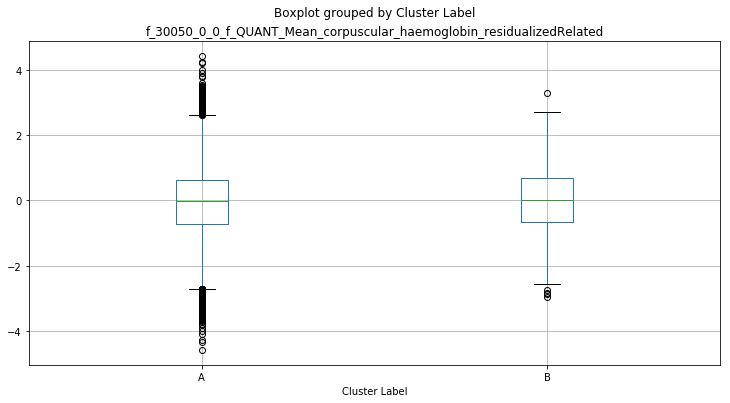

In [85]:
asthma_df_quant.boxplot(asthma_df_quant.columns[601],by='Cluster Label')

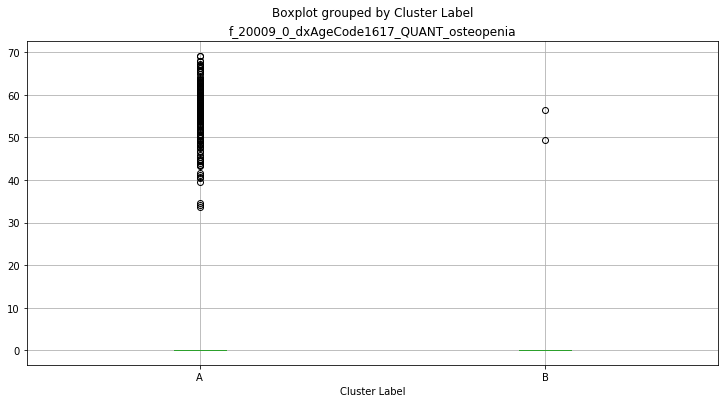

In [86]:
asthma_df_quant.boxplot(asthma_df_quant.columns[270],by='Cluster Label')

## Features that are lung function-specific

In [88]:
anova_df_lung=anova_df_significant[anova_df_significant['feature'].str.contains('FEV|FVC|cough|smok|asthma|tobacco|bronc|Lung|lung|PEF')]

In [89]:
anova_df_lung.shape

(45, 2)

In [90]:
anova_df_lung.head(20)

,feature,pvalue
84,f_22147_0_0_f_QUANT_Age_asthma_diagnosed_by_do...,3.875854e-71
5,f_22508_0_0_f_QUANT_Amount_of_tobacco_currentl...,2.604035e-14
92,f_22503_0_0_f_QUANT_Years_of_cough_on_most_days,3.865365e-11
74,f_20150_0_0_f_QUANT_Forced_expiratory_volume_i...,1.748077e-06
260,f_3063_0_f_QUANT_FEV1_maximumValue_forFEV1_Pred,4.976785e-06
337,f_20150_0_0_f_QUANT_Forced_expiratory_volume_i...,4.976785e-06
257,f_3063_0_f_QUANT_FEV1_maximumValue_strict,4.976785e-06
75,f_20151_0_0_f_QUANT_Forced_vital_capacity_FVC_...,5.417083e-06
256,f_3063_0_f_QUANT_FEV1_maximumValue,5.623551e-06
338,f_20151_0_0_f_QUANT_Forced_vital_capacity_FVC_...,6.571714e-06


In [91]:
asthma_df_important_features_lung=asthma_df_important_features[asthma_df_important_features['index'].isin(anova_df_lung.index)]

In [92]:
asthma_df_important_features_lung.head(10)

,index,importance
358,358,-1.673128
75,75,-1.820294
728,728,-1.877459
653,653,-1.877459
258,258,-1.902931
652,652,-1.926907
470,470,-1.928365
254,254,-1.953793
332,332,-2.034474
334,334,-2.049321


In [93]:
asthma_df_important_features_lung.shape

(45, 2)

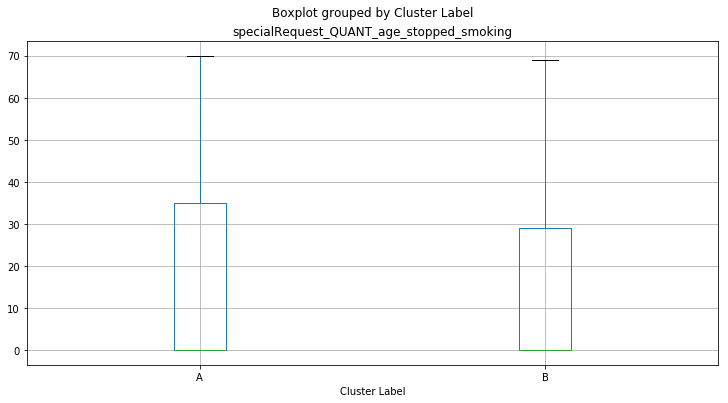

In [94]:
asthma_df_quant.boxplot(asthma_df_quant.columns[358],by='Cluster Label')

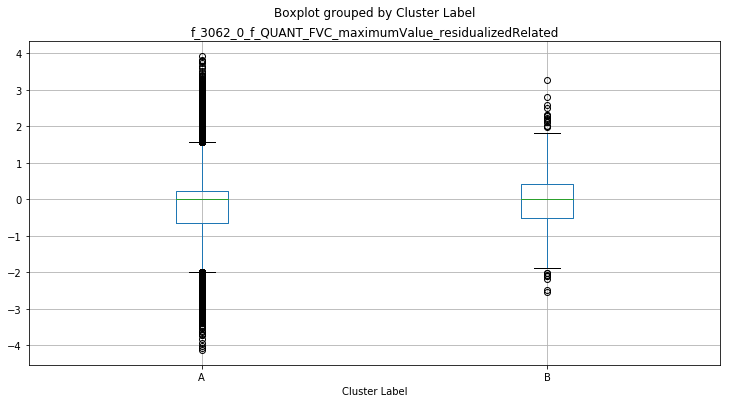

In [95]:
asthma_df_quant.boxplot(asthma_df_quant.columns[652],by='Cluster Label')

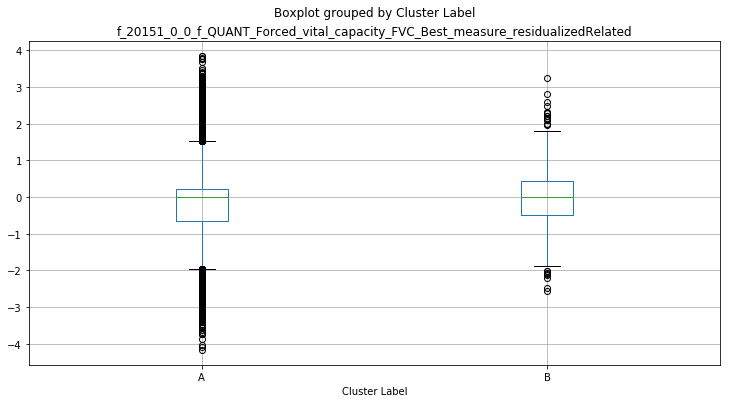

In [96]:
asthma_df_quant.boxplot(asthma_df_quant.columns[470],by='Cluster Label')

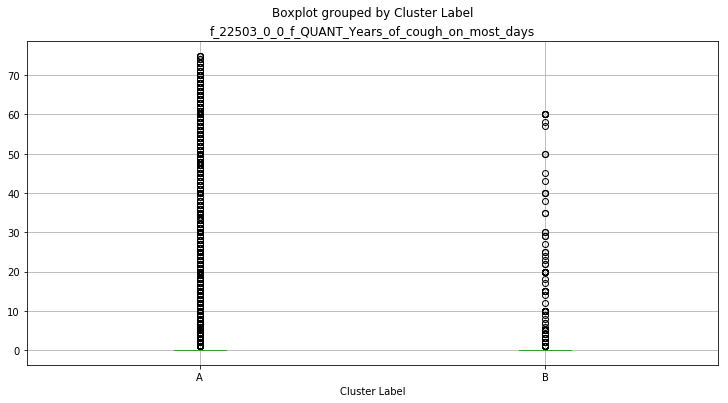

In [97]:
asthma_df_quant.boxplot(asthma_df_quant.columns[92],by='Cluster Label')

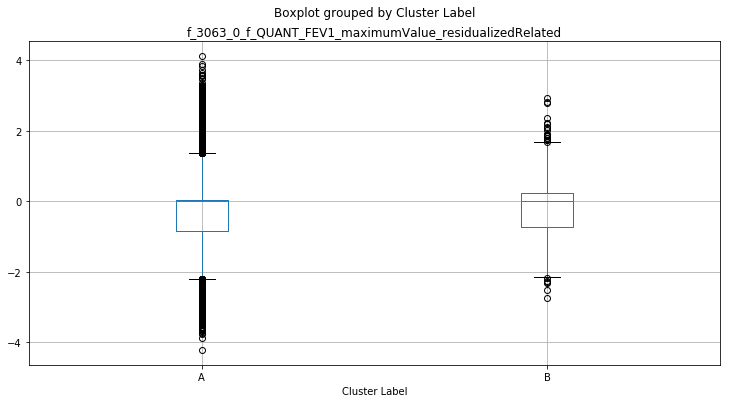

In [98]:
asthma_df_quant.boxplot(asthma_df_quant.columns[654],by='Cluster Label')

## Features that are blood specific

In [99]:
anova_df_blood=anova_df_significant[anova_df_significant['feature'].str.contains('LV|cardiac|Neutrophil|blood|Basophil|Platelet|Pulse|Heart|Cardiac|monocyte|heart|Reticulocyte')]

In [100]:
anova_df_blood.shape

(21, 2)

In [101]:
anova_df_blood

,feature,pvalue
483,f_22420_2_0_f_QUANT_LV_ejection_fraction_resid...,1.042056e-150
486,f_22423_2_0_f_QUANT_LV_stroke_volume_residuali...,7.103970e-90
743,specialRequest_QUANT_LVEDVi_residualizedRelated,7.915657e-48
484,f_22421_2_0_f_QUANT_LV_end_diastolic_volume_re...,5.879051e-19
488,f_22425_2_0_f_QUANT_Cardiac_index_residualized...,1.380493e-16
487,f_22424_2_0_f_QUANT_Cardiac_output_residualize...,2.977231e-09
485,f_22422_2_0_f_QUANT_LV_end_systolic_volume_res...,5.745267e-09
610,f_30140_0_0_f_QUANT_Neutrophill_count_residual...,5.284077e-07
596,f_30000_0_0_f_QUANT_White_blood_cell_leukocyte...,5.795774e-07
612,f_30160_0_0_f_QUANT_Basophill_count_residualiz...,4.686634e-05


In [102]:
asthma_df_important_features_blood=asthma_df_important_features[asthma_df_important_features['index'].isin(anova_df_blood.index)]

In [103]:
asthma_df_important_features_blood.head(10)

,index,importance
605,605,-1.540485
604,604,-1.575223
612,612,-1.665470
621,621,-1.885290
483,483,-1.920435
660,660,-2.009456
199,199,-2.009475
242,242,-2.145588
610,610,-2.146862
487,487,-2.151238


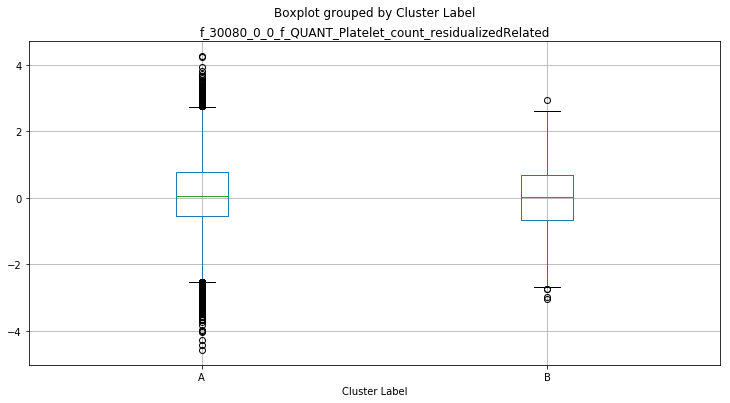

In [104]:
asthma_df_quant.boxplot(asthma_df_quant.columns[604],by='Cluster Label')

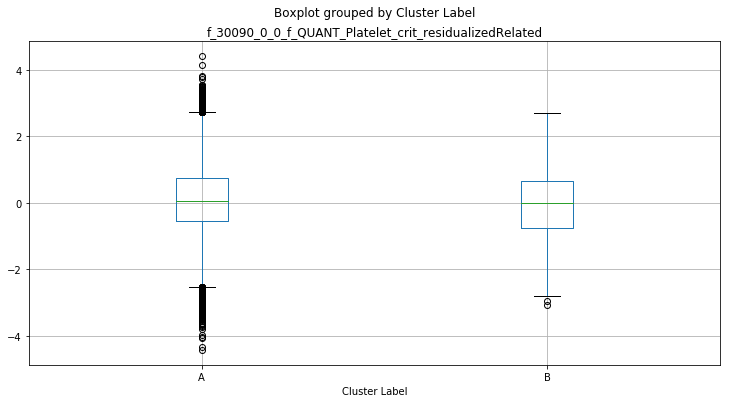

In [105]:
asthma_df_quant.boxplot(asthma_df_quant.columns[605],by='Cluster Label')

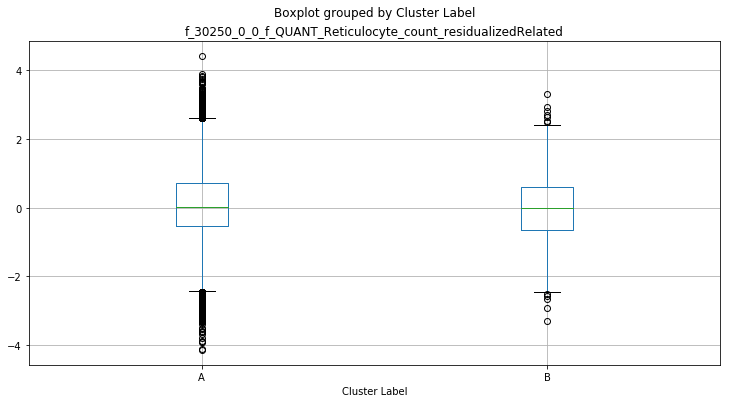

In [106]:
asthma_df_quant.boxplot(asthma_df_quant.columns[621],by='Cluster Label')

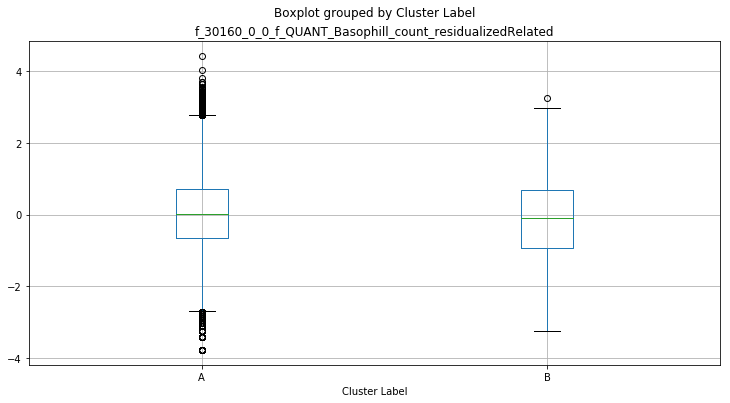

In [107]:
asthma_df_quant.boxplot(asthma_df_quant.columns[612],by='Cluster Label')

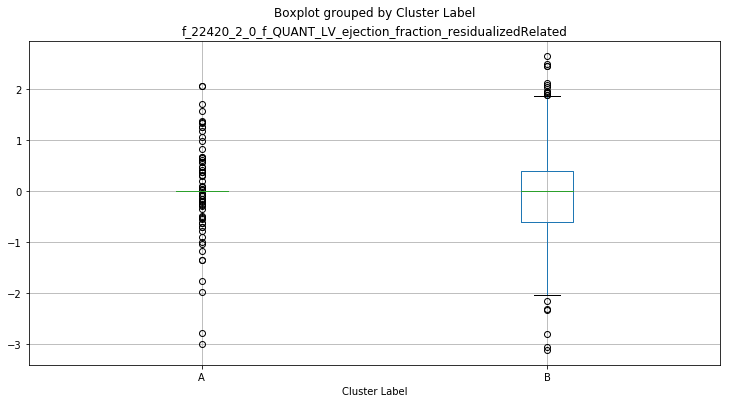

In [108]:
asthma_df_quant.boxplot(asthma_df_quant.columns[483],by='Cluster Label')

## Other features that are present in healthy patients

In [109]:
anova_df_healthy=anova_df_significant[anova_df_significant['feature'].str.contains('fat|bone|mass|grip|adipose|thigh|Waist|BMI|Hip|Ankle|Corneal|ocular')]

In [110]:
anova_df_healthy.shape

(123, 2)

In [111]:
anova_df_healthy.head(20)

,feature,pvalue
538,f_23247_2_0_f_QUANT_Android_tissue_fat_percent...,1.770227e-318
559,f_23268_2_0_f_QUANT_Leg_tissue_fat_percentage_...,5.645307e-277
546,f_23255_2_0_f_QUANT_Arm_tissue_fat_percentage_...,1.404960e-274
555,f_23264_2_0_f_QUANT_Gynoid_tissue_fat_percenta...,1.959677e-239
585,f_23308_2_0_f_QUANT_Pelvis_BMC_bone_mineral_co...,1.452724e-233
575,f_23284_2_0_f_QUANT_Trunk_fat_mass_residualize...,3.013261e-224
584,f_23307_2_0_f_QUANT_Pelvis_bone_area_residuali...,2.518905e-216
563,f_23272_2_0_f_QUANT_Leg_tissue_fat_percentage_...,8.851247e-209
548,f_23257_2_0_f_QUANT_Arms_fat_mass_residualized...,1.556919e-208
123,f_23205_2_0_f_QUANT_L1_L4_BMD_bone_mineral_den...,6.088499e-208


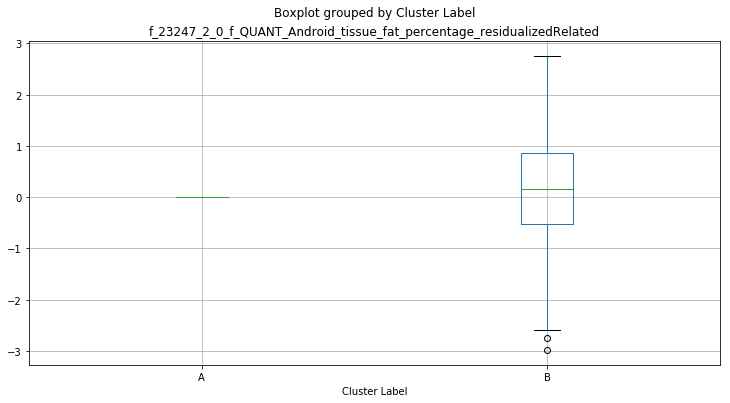

In [112]:
asthma_df_quant.boxplot(asthma_df_quant.columns[538],by='Cluster Label')

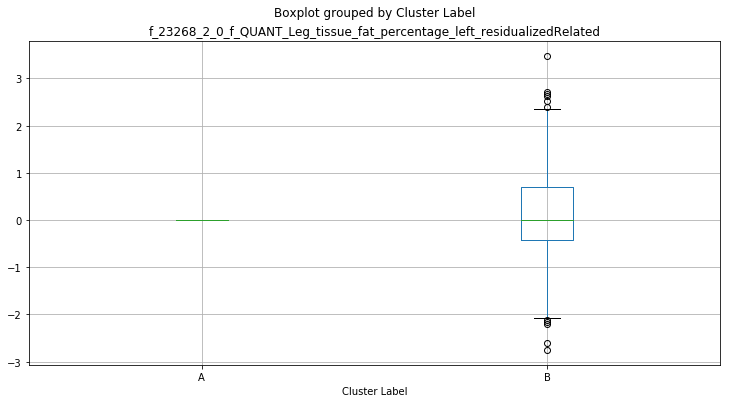

In [113]:
asthma_df_quant.boxplot(asthma_df_quant.columns[559],by='Cluster Label')

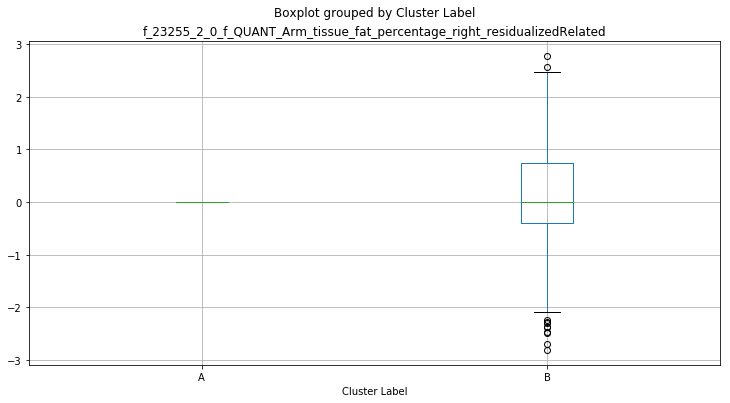

In [114]:
asthma_df_quant.boxplot(asthma_df_quant.columns[546],by='Cluster Label')

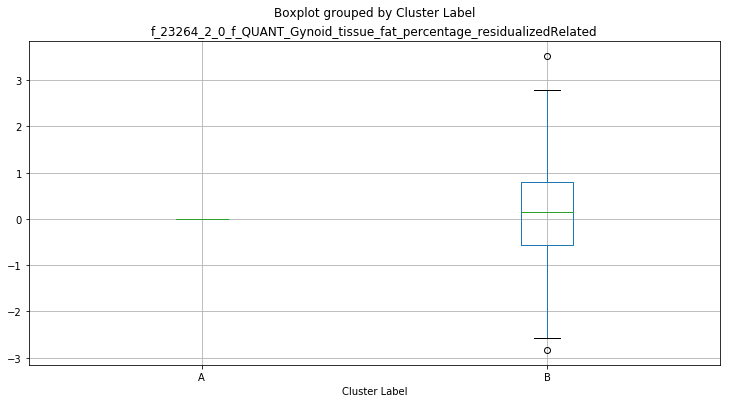

In [115]:
asthma_df_quant.boxplot(asthma_df_quant.columns[555],by='Cluster Label')

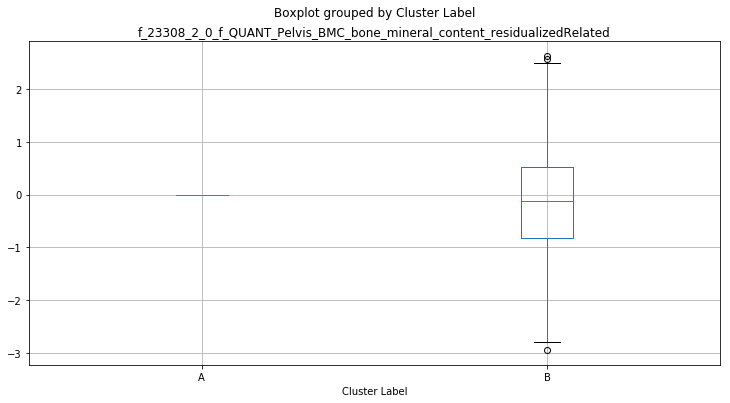

In [116]:
asthma_df_quant.boxplot(asthma_df_quant.columns[585],by='Cluster Label')

## Other features that may be specific to asthma

In [117]:
anova_df_other=anova_df_significant[~anova_df_significant['feature'].str.contains('fat|bone|mass|grip|adipose|thigh|Waist|BMI|Hip|Ankle|Corneal|ocular|LV|cardiac|Neutrophil|blood|Basophil|Platelet|Pulse|Heart|Cardiac|monocyte|heart|Reticulocyte|FEV|FVC|cough|smok|asthma|tobacco|bronc|Lung|lung|PEF')]

In [118]:
anova_df_other.shape

(67, 2)

In [119]:
anova_df_other.head(10)

,feature,pvalue
241,f_22200_0_0_f_QUANT_Year_of_birth,5.095021e-127
238,f_90012_0_0_f_QUANT_Overall_acceleration_average,9.937321e-117
78,f_20159_0_0_f_QUANT_Number_of_symbol_digit_mat...,1.776397e-106
454,f_12338_2_0_f_QUANT_P_duration_residualizedRel...,1.497283e-95
240,f_20156_0_0_f_QUANT_Duration_to_complete_numer...,3.322968e-78
239,f_20157_0_0_f_QUANT_Duration_to_complete_alpha...,9.090970e-71
592,f_12336_2_0_f_QUANT_Ventricular_rate_residuali...,4.119037e-65
493,f_22680_0_0_f_QUANT_Mean_carotid_IMT_intima_me...,2.245636e-17
639,f_22200_0_0_f_QUANT_Year_of_birth_residualized...,1.684329e-15
634,f_41142_0_0_f_QUANT_Episodes_containing_Diagno...,1.927940e-10


In [120]:
asthma_df_important_features_other=asthma_df_important_features[asthma_df_important_features['index'].isin(anova_df_other.index)]

In [121]:
asthma_df_important_features_other.head(10)

,index,importance
633,633,-1.679608
661,661,-1.773184
436,436,-1.876800
634,634,-1.885420
417,417,-1.905691
414,414,-1.911386
218,218,-1.914577
736,736,-1.963451
45,45,-1.964872
460,460,-1.966358


## Step 7: Write out Asthma Group Labels for different cohorts 

In [138]:
cohort_labels_df=pd.get_dummies(asthma_df_quant['Cluster Label']).rename(columns={'A':'Asthma_CohortA','B':'Asthma_CohortB'})
cohort_labels_df['Asthma_CohortAnotB']=cohort_labels_df['Asthma_CohortA'] 

In [139]:
cohort_labels_df.head()

,Asthma_CohortA,Asthma_CohortB,Asthma_CohortAnotB
0,1,0,1
1,1,0,1
2,1,0,1
3,1,0,1
4,1,0,1


In [152]:
asthma_df_full_gwas=pd.read_csv('ukbb_asthma_full.csv',sep='\t',usecols=['IID','PC1','PC2','PC3','PC4','PC5','PC6','PC7',
                                                           'PC8','PC9','PC10','sex','age'])

In [153]:
asthma_df_full_gwas.head()

,IID,sex,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,age
0,1000149,2,-0.0012,0.0002,-0.0003,-0.0002,-0.0005,-0.0009,-0.0006,0.0024,0.0013,-0.0004,45
1,1000306,2,-0.0011,-0.0025,0.0006,-0.0021,0.0000,0.0021,-0.0013,-0.0002,-0.0022,0.0029,69
2,1000418,1,-0.0001,-0.0004,0.0011,0.0002,-0.0003,-0.0003,0.0016,0.0022,0.0005,0.0001,67
3,1000607,2,-0.0001,0.0007,0.0003,-0.0007,0.0002,0.0002,0.0000,0.0011,-0.0003,-0.0010,47
4,1000984,2,-0.0009,-0.0012,0.0004,-0.0009,0.0011,0.0005,-0.0021,-0.0001,-0.0007,-0.0003,67


In [154]:
cohort_labels_df.head()

,Asthma_CohortA,Asthma_CohortB,Asthma_CohortAnotB
0,1,0,1
1,1,0,1
2,1,0,1
3,1,0,1
4,1,0,1


In [172]:
asthma_df_full_gwas=asthma_df_full_gwas.join(cohort_labels_df)
asthma_df_full_gwas.to_csv('ukbb_asthma_cohort_annotation.csv')

In [165]:
asthma_df_full_not_asthma=pd.read_csv('ukbb_not_asthma_full_gwas.csv',sep='\t').drop(columns=['Unnamed: 0'])

In [168]:
asthma_df_full_not_asthma['Asthma_CohortA']=0
asthma_df_full_not_asthma['Asthma_CohortB']=0
asthma_df_full_not_asthma['Asthma_CohortAnotB']=np.NaN

In [193]:
ukbb_df_full_gwas=pd.concat([asthma_df_full_gwas,asthma_df_full_not_asthma]).reset_index().drop(columns='index')

In [194]:
ukbb_df_full_gwas=ukbb_df_full_gwas[['IID','PC1','PC2','PC3','PC4','PC5','PC6','PC7',
'PC8','PC9','PC10','sex','age','Asthma_CohortA','Asthma_CohortB','Asthma_CohortAnotB']]

In [196]:
ukbb_df_full_gwas.to_csv('ukbb_asthma_cohorts_gwas_annotation.csv',index=False)

In [8]:
import pyodbc
import pandas as pd

conn = pyodbc.connect("DSN=impaladsn", autocommit=True) 
data_df = pd.read_sql("SELECT * FROM gene_gwas.gwas_results ORDER BY pval DESC  LIMIT 20;", conn) 
data_df.head(20)
 
# order by wpval, having specific value 

,pos,ref,alt,beta,se,pval,pval_raw,rsq,freq,entity,feature,analysis,chrom
0,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,None,None,ukb_ibd_ni,1
1,NaN,NA,NA,NaN,NaN,NaN,NaN,NaN,NaN,ENSG00000259384,ENSG00000259384,qtl_protein_blood_folkersen2017,13
2,61719070.0,T,C,NaN,NaN,NaN,NaN,NaN,0.999500,ENSG00000149968,ENSG00000149968,qtl_protein_blood_folkersen2017,11
3,675.0,NA,NA,NaN,NaN,NaN,NaN,NaN,NaN,ENSG00000117525,ENSG00000117525,qtl_protein_blood_folkersen2017,15
4,48868528.0,C,T,NaN,NaN,NaN,NaN,NaN,0.866300,ENSG00000117525,ENSG00000117525,qtl_protein_blood_folkersen2017,12
5,NaN,NA,NA,NaN,NaN,NaN,NaN,NaN,NaN,ENSG00000101017,ENSG00000101017,qtl_protein_blood_folkersen2017,12
6,67660548.0,G,A,NaN,NaN,NaN,NaN,NaN,0.991100,ENSG00000262655,ENSG00000262655,qtl_protein_blood_folkersen2017,15
7,NaN,0.314821,0.000741399,NaN,NaN,NaN,NaN,0.520000,0.998848,None,None,ukb_ibd_ni,4
8,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,None,None,ukb_ibd_ni,2
9,311862.0,G,GGAGA,0.000000e+00,NaN,1.0,1.0,NaN,NaN,ENSG00000266171,ENSG00000266171,gtex7_brain_hypothalamus,18
